In [1]:
import numpy as np
import pandas as pd

import glob
import os
import lenstronomy.Util.kernel_util as kernel_util
import lenstronomy.Util.util as util
#from astroObjectAnalyser.DataAnalysis.analysis import Analysis
from astroObjectAnalyser.astro_object_superclass import StrongLensSystem
import numpy as np
import h5py

from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
import yaml

from astropy.coordinates import SkyCoord
from astropy import units as u



In [2]:
Main_dir = '../lenses/'

In [3]:
def PreProcess(object_name,band,camera,ra,dec,numPix,single_exposure=False,show_plot=True):

    output_data_dir = os.path.join(Main_dir, '{}/{}_{}/reduced_data/'.format(object_name,band,camera))    
    cutout_dir = os.path.join(Main_dir, 'cutout/{}/'.format(object_name,band,camera))   
    
    system_name = object_name
    ra_str = '{}:{}:{}'.format(ra[0:2],ra[3:5],ra[6:11])
    dec_str = '{}:{}:{}'.format(dec[0:3],dec[4:6],dec[7:12])
        
    # options for cutout
   # numPix = 150 # only even numbers allowed so far, 6'

    system = StrongLensSystem(system_name)
    system.add_info_attribute('ra_str', ra_str)
    system.add_info_attribute('dec_str', dec_str)

    
    image_name = band  
    if band == "F160W":
        image_filename = '{}_{}_drz_sci.fits'.format(system_name,band)
        wht_filename = "{}_{}_drz_wht.fits".format(system_name,band)
    else: 
        image_filename = '{}_{}_drc_sci.fits'.format(system_name,band)
        wht_filename = "{}_{}_drc_wht.fits".format(system_name,band)


    # import the data
    local_filename = os.path.join(output_data_dir, image_filename)
    local_wht_filename = os.path.join(output_data_dir, wht_filename)
    #print(local_filename)


    # add image data instance (see astroObjectAnalyser)
    system.add_image_data_init(image_name, local_filename=local_filename, local_psf_filename=None, 
                        local_wht_filename=local_wht_filename,
                           ra=system.ra, dec=system.dec, ra_cutout_cent=system.ra, dec_cutout_cent=system.dec,
                           cutout_scale=numPix, data_type='HST_new')

    #print(system.ra, system.dec)
    #print(system.ra_str, system.dec_str)
    
    data_cutout = system.get_cutout_image(image_name, numPix, force=True)  # if force=True, a new cutout with the new options will be made

    #%matplotlib notebook

    #  plt.matshow(np.log10(data_cutout), origin='lower')
    #  plt.autoscale(False)

    ra0, dec0 = system.pix2coord(image_name, 20, 20)
    xx_, yy_ = system.coord2pix(image_name, ra0, dec0)
    xx_ra, yy_ra = system.coord2pix(image_name, ra0 + 1, dec0)
    xx_dec, yy_dec = system.coord2pix(image_name, ra0, dec0 + 1)
    #  plt.plot([xx_,xx_ra],[yy_,yy_ra], linewidth=2, color='k')
    #  plt.plot([xx_,xx_dec],[yy_,yy_dec], linewidth=2, color='r')
    #  plt.show()
   

    deltaPix, _ = system.get_pixel_scale(image_name)
    deltaPix *= 3600  # convert into arcsec
    print(deltaPix)
    # get mean and sigma_bkd of image (computed by SourceExtractor)
    mean, sigma_b = system.get_background(image_name)
    ccd_gain = system.get_CCD_gain(image_name)
    print(mean, sigma_b)
    print(ccd_gain)

    # we subtract the mean background estimate from the cutout image
    data_reduced = (data_cutout - mean)#*mask_off


    # get exposure time
    exp_time = system.get_exposure_time(image_name)

    # here we set the coordinate grid (rectangular)
    ra_at_xy_0, dec_at_xy_0 = system.coord_at_pixel_0(image_name)
    x_at_radec_0, y_at_radec_0 = system.pixel_at_angle_0(image_name)
    Matrix = system.get_transform_matrix_angle2pix(image_name)
    Matrix_inv = system.get_transform_matrix_pix2angle(image_name)
    cos_dec = np.cos(system.dec/360*2*np.pi)

    # get weight map (effective exposure time per pixel)
    if not single_exposure:
        if camera == "WFPC2":
            wht_map = system.get_exposure_map(image_name)* ccd_gain  # WFPC2 different units
        else:
            wht_map = system.get_exposure_map(image_name)  
            
        wht_map[wht_map <= 0] = 10**(-10)  # just making sure that there are non-negative exposure times
    else:
        #Fill in exposure time frow fraw file 
        raw_data_dir = os.path.join(Main_dir, '{}/{}_{}/raw_data/*.fits'.format(object_name,band,camera)) 
        assert len(glob.glob(raw_data_dir)) == 1
        raw_file = fits.open(glob.glob(raw_data_dir)[0])
        exp_time = raw_file[0].header["EXPTIME"]
        wht_map = np.ones(np.shape(data_reduced))*exp_time


   # plt.matshow(np.log10(wht_map), origin='lower')
   # plt.autoscale(False)

    ra0, dec0 = system.pix2coord(image_name, 20, 20)
    xx_, yy_ = system.coord2pix(image_name, ra0, dec0)
    xx_ra, yy_ra = system.coord2pix(image_name, ra0 + 1, dec0)
    xx_dec, yy_dec = system.coord2pix(image_name, ra0, dec0 + 1)
    #  plt.plot([xx_,xx_ra],[yy_,yy_ra], linewidth=2, color='k')
    #  plt.plot([xx_,xx_dec],[yy_,yy_dec], linewidth=2, color='r')
 
    print(system.coord2pix(image_name, system.ra+ra_at_xy_0, system.dec+dec_at_xy_0))

    x_0, y_0 = system.pixel_at_angle_0(image_name)
    # plt.plot(x_0, y_0, 'ob')
    # plt.colorbar()
    # plt.show()
    if show_plot:
        plt.matshow(np.log10(data_reduced), origin='lower')
        plt.show()
    
    # Make cut-out directory

    if os.path.isdir(cutout_dir):   
        pass
    else:
        os.makedirs(cutout_dir)
   

    # save data configurations ih hdf5 format
    data_filename = 'image_{}_{}.h5'.format(system_name,band)
    local_data_filename = os.path.join(cutout_dir, data_filename)
    f = h5py.File(local_data_filename, "w")
    dset = f.create_dataset('image_data', data=data_reduced)
    dset = f.create_dataset('background_rms', data=sigma_b)
    dset = f.create_dataset('exposure_time', data=wht_map)
    dset = f.create_dataset('ra_at_xy_0', data=ra_at_xy_0)
    dset = f.create_dataset('dec_at_xy_0', data=dec_at_xy_0)
    dset = f.create_dataset('transform_pix2angle', data=Matrix_inv)
    f.close()
    
  #  print("~~~~~~~~~~~~~~~~~~")

    return data_reduced, exp_time




In [4]:
def CCD_Adder(object_name,band,camera):
    """
    Add CCDGAIN in FITS Header
    """

    output_data_dir = os.path.join(Main_dir, '{}/{}_{}/reduced_data/'.format(object_name,band,camera))   
    system_name = object_name
    
    flc_files = glob.glob(output_data_dir+'/*sci.fits')
    hdul = fits.open(flc_files[0])

    try:
        Gain=( hdul[0].header['CCDGAIN'])
        print(Gain)
    except:
        Gain=( hdul[0].header['ATODGAIN'])
        hdr = hdul[0].header
        hdr.set('CCDGAIN ', Gain)
        hdul.writeto(flc_files[0],overwrite=True)
        print(Gain)

    hdul.close()
    

In [5]:
def CR_masker(img,object_name,band,exp_time):
    image = img*exp_time

  #  print(np.average(image))

    norm = simple_norm(image, 'sqrt', percent=99.)
 #   plt.imshow(image, norm=norm, origin='lower', cmap='viridis')
 #   plt.show()


    # create an instance of deepCR with specified model configuration
    mdl = deepCR(mask="ACS-WFC-F606W-2-32",    inpaint="ACS-WFC-F606W-2-32",  device="CPU")

    # apply to input image
    mask, cleaned_image = mdl.clean(image, threshold = 0.5)
    # best threshold is highest value that generate mask covering full extent of CR
    # choose threshold by visualizing outputs.



    #norm = simple_norm(cleaned_image, 'sqrt', percent=99.)
    plt.imshow(cleaned_image, norm=norm, origin='lower', cmap='viridis')
    plt.show()
    
    data_filename = 'mask_{}_{}.h5'.format(object_name,band)
    cutout_dir = os.path.join(Main_dir, 'cutout/{}/'.format(object_name))  
    local_data_filename = os.path.join(cutout_dir, data_filename)
    f = h5py.File(local_data_filename, "w")
    dset = f.create_dataset('mask', data=mask)
    f.close()
    

 #   plt.imshow(mask, origin='lower')
 #   plt.show()





In [6]:
def Coord_finder(oldra,olddec,ra_offset,dec_offset):

    ra=oldra
    dec=olddec
    ra_str = '{}h{}m{}s'.format(ra[0:2],ra[3:5],ra[6:12])
    dec_str = '{}d{}m{}s'.format(dec[0:3],dec[4:6],dec[7:12])
  #  print(dec_str)
    hcg7_center = SkyCoord(ra_str, dec_str , frame='icrs', unit='deg')  # using degrees directly
    new_ra = hcg7_center.ra.degree+(ra_offset/3600)
    new_dec = hcg7_center.dec.degree+(dec_offset/3600)

    hcg6_center = SkyCoord(new_ra, new_dec, frame='icrs', unit='deg')  # using degrees directly
 #   print(hcg6_center.ra.hms )
  #  print(hcg6_center.dec.dms )

    f1=int(hcg6_center.ra.hms[0])
    f2=int(hcg6_center.ra.hms[1])
    f3=(hcg6_center.ra.hms[2])
    
    f4=abs(int(hcg6_center.dec.dms[0]))
    f5=abs(int(hcg6_center.dec.dms[1]))
    f6=abs((hcg6_center.dec.dms[2]))


    new_ra_str = '{} {} {}'.format(f'{f1:02d}',f'{f2:02d}',"%06.3f"%f3)
    
    print(new_dec)
    
    if (new_dec) >= 0:
        new_dec_str = '+{} {} {}'.format(f'{f4:02d}',f'{f5:02d}',"%06.3f"%f6)
    else:
        new_dec_str = '-{} {} {}'.format(f'{f4:02d}',f'{f5:02d}',"%06.3f"%f6)
  #  print(new_ra_str)
  #  print(new_dec_str)
    return [new_ra_str,new_dec_str]        


In [7]:
def PreProcessor(object_name,band,camera, RA, Dec, cutout_size, calibrate=True):
    print("Processing Lens :  ",object_name,band )
    
    #Add 'ATODGAIN' HEADER to WFPC2 images
    if camera == "WFPC2":
        CCD_Adder(object_name,band,camera)  

    #Check if single is needed:
    raw_data_dir = os.path.join(Main_dir, '{}/{}_{}/raw_data/*.fits'.format(object_name,band,camera))
    if len(glob.glob(raw_data_dir)) == 1:
        single_value=True          
    else:
        single_value=False         
    
    # Run Preprocess
    img,exp_time = PreProcess(object_name,band,camera,RA,Dec,cutout_size, 
                              single_exposure= single_value,show_plot=True)
        
    if calibrate and not single_value:
        # Open h5 file and check offset
        cutout_dir = os.path.join(Main_dir, 'cutout/{}/'.format(object_name)) 
        local_data_filename = os.path.join(cutout_dir, 'image_{}_{}.h5'.format(object_name,band))

        f = h5py.File(local_data_filename, 'r')

        image_data = f['image_data'][()]
        pixel_size = 0.05 #Becareful
        f.close()

        midpoint = int(len(image_data)/2)
        offset = [int(midpoint-np.where(image_data ==image_data.max())[1])*pixel_size,
                  int(midpoint-np.where(image_data ==image_data.max())[0])*pixel_size]
        
        new_Coords = Coord_finder(RA ,Dec,offset[0],-offset[1])
        print(new_Coords)


        # Run Preprocess again
        img,exp_time = PreProcess(object_name, band, camera, new_Coords[0], new_Coords[1], cutout_size,
                                  single_exposure= single_value,show_plot=True)
    
    # Run CR_masker if needed 
    if single_value:
        CR_masker(img,object_name,band,exp_time)

        
    return None 


Processing Lens :   SDSSJ1627-0053 F390W
the center of the image is at pixel coordinates 2052.572620, 3203.115973.
0.039999999999996795
ccd gain = 1.5
No filter file found, using default filter
No NNW file found, using default NNW config
sextractor command: sex ../lenses/SDSSJ1627-0053/F390W_WFC3/reduced_data/SDSSJ1627-0053_F390W_drc_sci.fits -c .pysex.sex -GAIN 10242.0 -CATALOG_NAME .pysex.cat -PARAMETERS_NAME .pysex.param -FILTER_NAME .pysex.conv -STARNNW_NAME .pysex.nnw
0.0001252812508028 0.001653219223954
1.5
the center of the image is at pixel coordinates 2052.572620, 3203.115973.
separate exposure map loaded
(-6148.075495002228, -560.5063658383148)


/home/s1/chinyi/.conda/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in log10


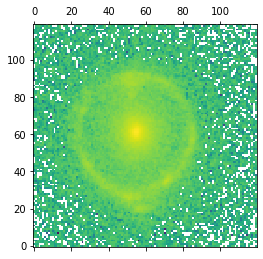

Processing Lens :   SDSSJ1627-0053 F555W
the center of the image is at pixel coordinates 2186.915389, 3188.080062.
0.049999999999998025
ccd gain = 2
No filter file found, using default filter
No NNW file found, using default NNW config
sextractor command: sex ../lenses/SDSSJ1627-0053/F555W_ACS/reduced_data/SDSSJ1627-0053_F555W_drc_sci.fits -c .pysex.sex -GAIN 4320.0 -CATALOG_NAME .pysex.cat -PARAMETERS_NAME .pysex.param -FILTER_NAME .pysex.conv -STARNNW_NAME .pysex.nnw
0.0004256619722582 0.004988440312445
2
the center of the image is at pixel coordinates 2186.915389, 3188.080062.
separate exposure map loaded
(-299.63795514104163, -4929.806143450358)


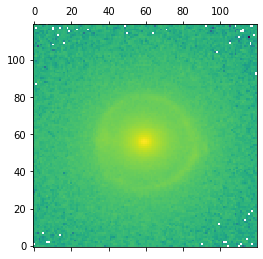

Processing Lens :   SDSSJ1627-0053 F814W
the center of the image is at pixel coordinates 2186.960909, 3187.758987.
0.04999999999999792
ccd gain = 2
No filter file found, using default filter
No NNW file found, using default NNW config
sextractor command: sex ../lenses/SDSSJ1627-0053/F814W_ACS/reduced_data/SDSSJ1627-0053_F814W_drc_sci.fits -c .pysex.sex -GAIN 4448.0 -CATALOG_NAME .pysex.cat -PARAMETERS_NAME .pysex.param -FILTER_NAME .pysex.conv -STARNNW_NAME .pysex.nnw
0.0001398558088113 0.005825003609061
2
the center of the image is at pixel coordinates 2186.960909, 3187.758987.
separate exposure map loaded
(-299.6379561516697, -4929.806148716208)


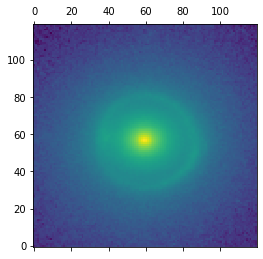

In [8]:
PreProcessor('SDSSJ1627-0053','F390W','WFC3', '16 27 46.437','-00 53 57.62', 120, calibrate=False)
PreProcessor('SDSSJ1627-0053','F555W','ACS' , '16 27 46.437','-00 53 57.62', 120, calibrate=False)
PreProcessor('SDSSJ1627-0053','F814W','ACS' , '16 27 46.437','-00 53 57.62', 120, calibrate=False)